In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 


In [3]:
dataDir='/media/xinyi/T7 Shield/neuro'
phenoLabels=['Control','AD','IPD','FTLD-TDPC','PSP']
stains=['DAPI','GFAP','MAP2','LMNB']

In [4]:
savedir_processed=os.path.join(dataDir,'processed')

with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
with open(os.path.join(savedir_processed,'allCoord'), 'rb') as output:
    allCoord=pickle.load(output)
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientID=pickle.load(output)
with open(os.path.join(savedir_processed,'allCat'), 'rb') as output:
    allCat=pickle.load(output)

In [5]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allImgNames.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allImgNames.shape[0])]
testIdx=allIdx[int(pctVal*allImgNames.shape[0]):(int(pctVal*allImgNames.shape[0])+int(pctTest*allImgNames.shape[0]))]
trainIdx=allIdx[(int(pctVal*allImgNames.shape[0])+int(pctTest*allImgNames.shape[0])):]

In [6]:
with open(os.path.join(savedir_processed,'train_cnnvae_trainIdx'), 'wb') as output:
    pickle.dump(trainIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(savedir_processed,'train_cnnvae_valIdx'), 'wb') as output:
    pickle.dump(valIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(savedir_processed,'train_cnnvae_testIdx'), 'wb') as output:
    pickle.dump(testIdx, output, pickle.HIGHEST_PROTOCOL)

In [6]:
#VAE settings
seed=3
epochs=1000
saveFreq=100
lr=0.00001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*4*4
fc_dim2=6000


kl_weight=0.0000001
model_str='cnn_vae'

name='exp0_segNuc'
if 'minmax' in name:
    print('minmax by crop')
    with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax'), 'rb') as output:
        allImg=pickle.load(output)
elif 'segNuc' in name:
    print('minmax by crop+nucSeg')
    with open(os.path.join(savedir_processed,'allImgs_noMaxPerc_minmax_segNuc'), 'rb') as output:
        allImg=pickle.load(output)
else:
    with open(os.path.join(savedir_processed,'allImgs'), 'rb') as output:
        allImg=pickle.load(output)
stain_train='all'
if stain_train !='all':
    stainIdx=stains.index(stain_train)
    allImg=allImg[:,[stainIdx]]
    print(allImg.shape)
logsavepath=os.path.join(dataDir,'results','log','cnnvae'+name+stain_train)
modelsavepath=os.path.join(dataDir,'results','models','cnnvae'+name+stain_train)
plotsavepath=os.path.join(dataDir,'results','plots','cnnvae'+name+stain_train)


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

minmax by crop+nucSeg


In [7]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if stain_train!='all':
    nc=1
else:
    nc=4
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, nc, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()


modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [8]:
use_cuda=True
def train(epoch):
    t = time.time()
    modelcnn.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allImg[trainIdx_i])

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerCNN.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerCNN.step()

    loss_kl_train_all=loss_kl_train_all/ntrainBatches
    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        modelcnn.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg[valIdx_i])
            if use_cuda:
                valInput=valInput.cuda().float()
            recon,z, mu, logvar = modelcnn(valInput)

            loss_val=loss_x(recon, valInput).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_kl_train_all,loss_x_train_all,loss_val_all

    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == (saveFreq-1):
        torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

Epoch: 0000 loss_train: 0.1545 loss_kl_train: 133.9721 loss_x_train: 0.1545 loss_val: 0.1151 time: 48.9505s
Epoch: 0001 loss_train: 0.0969 loss_kl_train: 13.0242 loss_x_train: 0.0969 loss_val: 0.0796 time: 44.1216s
Epoch: 0002 loss_train: 0.0681 loss_kl_train: 13.6863 loss_x_train: 0.0681 loss_val: 0.0560 time: 44.8509s
Epoch: 0003 loss_train: 0.0487 loss_kl_train: 14.1814 loss_x_train: 0.0487 loss_val: 0.0406 time: 44.9391s
Epoch: 0004 loss_train: 0.0356 loss_kl_train: 15.2888 loss_x_train: 0.0356 loss_val: 0.0300 time: 45.0229s
Epoch: 0005 loss_train: 0.0265 loss_kl_train: 17.4064 loss_x_train: 0.0265 loss_val: 0.0225 time: 44.9781s
Epoch: 0006 loss_train: 0.0202 loss_kl_train: 20.1823 loss_x_train: 0.0202 loss_val: 0.0176 time: 45.0394s
Epoch: 0007 loss_train: 0.0158 loss_kl_train: 22.8010 loss_x_train: 0.0158 loss_val: 0.0141 time: 44.9637s
Epoch: 0008 loss_train: 0.0129 loss_kl_train: 25.6433 loss_x_train: 0.0129 loss_val: 0.0116 time: 44.9457s
Epoch: 0009 loss_train: 0.0106 loss_

Epoch: 0080 loss_train: 0.0016 loss_kl_train: 113.9476 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.6484s
Epoch: 0081 loss_train: 0.0016 loss_kl_train: 114.1177 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.7372s
Epoch: 0082 loss_train: 0.0016 loss_kl_train: 114.2874 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.7403s
Epoch: 0083 loss_train: 0.0016 loss_kl_train: 114.4515 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.6833s
Epoch: 0084 loss_train: 0.0016 loss_kl_train: 114.6092 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.7920s
Epoch: 0085 loss_train: 0.0016 loss_kl_train: 114.7640 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.7227s
Epoch: 0086 loss_train: 0.0016 loss_kl_train: 114.9206 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.6999s
Epoch: 0087 loss_train: 0.0016 loss_kl_train: 115.0687 loss_x_train: 0.0016 loss_val: 0.0016 time: 44.6816s
Epoch: 0088 loss_train: 0.0016 loss_kl_train: 115.2136 loss_x_train: 0.0015 loss_val: 0.0016 time: 44.8490s
Epoch: 0089 loss_train: 0.00

Epoch: 0156 loss_train: 0.0013 loss_kl_train: 120.7650 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.6168s
Epoch: 0157 loss_train: 0.0013 loss_kl_train: 120.8132 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.7093s
Epoch: 0158 loss_train: 0.0013 loss_kl_train: 120.8633 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.7139s
Epoch: 0159 loss_train: 0.0013 loss_kl_train: 120.9186 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.6811s
Epoch: 0160 loss_train: 0.0013 loss_kl_train: 120.9713 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.5075s
Epoch: 0161 loss_train: 0.0013 loss_kl_train: 121.0240 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.7531s
Epoch: 0162 loss_train: 0.0013 loss_kl_train: 121.0725 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.6644s
Epoch: 0163 loss_train: 0.0013 loss_kl_train: 121.1186 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.6794s
Epoch: 0164 loss_train: 0.0013 loss_kl_train: 121.1704 loss_x_train: 0.0013 loss_val: 0.0013 time: 44.7706s
Epoch: 0165 loss_train: 0.00

Epoch: 0232 loss_train: 0.0012 loss_kl_train: 123.3336 loss_x_train: 0.0012 loss_val: 0.0012 time: 44.4345s
Epoch: 0233 loss_train: 0.0012 loss_kl_train: 123.3564 loss_x_train: 0.0012 loss_val: 0.0012 time: 44.4286s
Epoch: 0234 loss_train: 0.0012 loss_kl_train: 123.3800 loss_x_train: 0.0012 loss_val: 0.0012 time: 44.3072s
Epoch: 0235 loss_train: 0.0012 loss_kl_train: 123.4082 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.4776s
Epoch: 0236 loss_train: 0.0012 loss_kl_train: 123.4328 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.6932s
Epoch: 0237 loss_train: 0.0012 loss_kl_train: 123.4570 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.6013s
Epoch: 0238 loss_train: 0.0012 loss_kl_train: 123.4787 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.6720s
Epoch: 0239 loss_train: 0.0012 loss_kl_train: 123.5005 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.6394s
Epoch: 0240 loss_train: 0.0012 loss_kl_train: 123.5186 loss_x_train: 0.0011 loss_val: 0.0012 time: 44.5829s
Epoch: 0241 loss_train: 0.00

Epoch: 0308 loss_train: 0.0011 loss_kl_train: 124.5267 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.4147s
Epoch: 0309 loss_train: 0.0011 loss_kl_train: 124.5364 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.3095s
Epoch: 0310 loss_train: 0.0011 loss_kl_train: 124.5525 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.2383s
Epoch: 0311 loss_train: 0.0011 loss_kl_train: 124.5676 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.5504s
Epoch: 0312 loss_train: 0.0011 loss_kl_train: 124.5846 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.3869s
Epoch: 0313 loss_train: 0.0011 loss_kl_train: 124.5922 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.3890s
Epoch: 0314 loss_train: 0.0011 loss_kl_train: 124.6016 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.4791s
Epoch: 0315 loss_train: 0.0011 loss_kl_train: 124.6143 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.4639s
Epoch: 0316 loss_train: 0.0011 loss_kl_train: 124.6317 loss_x_train: 0.0011 loss_val: 0.0011 time: 44.4843s
Epoch: 0317 loss_train: 0.00

Epoch: 0384 loss_train: 0.0010 loss_kl_train: 125.2259 loss_x_train: 0.0010 loss_val: 0.0010 time: 44.7284s
Epoch: 0385 loss_train: 0.0010 loss_kl_train: 125.2337 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.1030s
Epoch: 0386 loss_train: 0.0010 loss_kl_train: 125.2400 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.2142s
Epoch: 0387 loss_train: 0.0010 loss_kl_train: 125.2504 loss_x_train: 0.0010 loss_val: 0.0010 time: 44.9413s
Epoch: 0388 loss_train: 0.0010 loss_kl_train: 125.2604 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.0094s
Epoch: 0389 loss_train: 0.0010 loss_kl_train: 125.2704 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.0546s
Epoch: 0390 loss_train: 0.0010 loss_kl_train: 125.2813 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.0195s
Epoch: 0391 loss_train: 0.0010 loss_kl_train: 125.2901 loss_x_train: 0.0010 loss_val: 0.0010 time: 44.9869s
Epoch: 0392 loss_train: 0.0010 loss_kl_train: 125.2959 loss_x_train: 0.0010 loss_val: 0.0010 time: 45.0394s
Epoch: 0393 loss_train: 0.00

KeyboardInterrupt: 

In [9]:
torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))

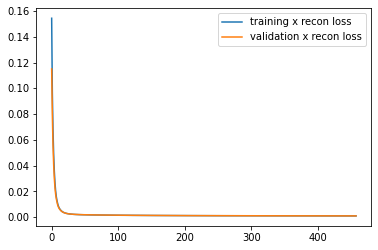

In [10]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [13]:
#test loss - allChannels; minmax by crop; nucSeg
use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(458)+'.pt')))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allImg[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = modelcnn(testInput)

        loss_test=loss_x(recon, testInput).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
print(loss_test_all)

0.0009971554540336514


0
DAPI


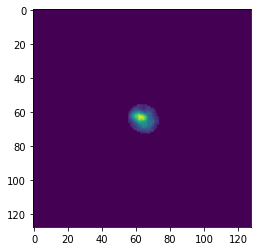

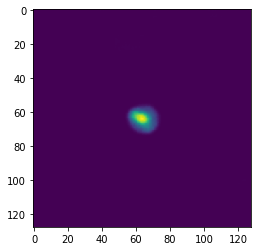

GFAP


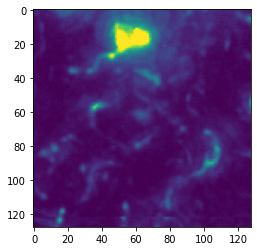

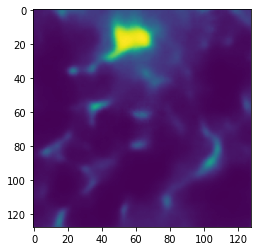

MAP2


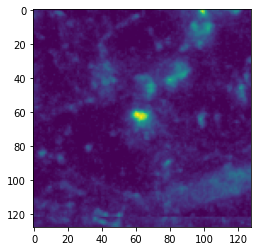

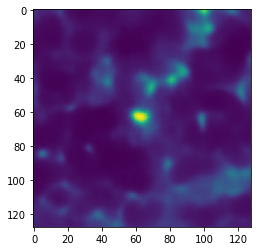

LMNB


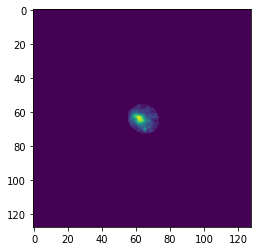

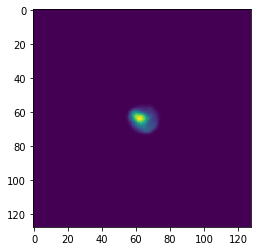

1
DAPI


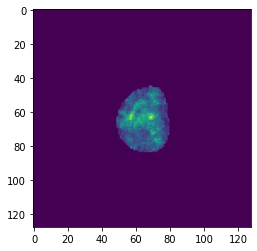

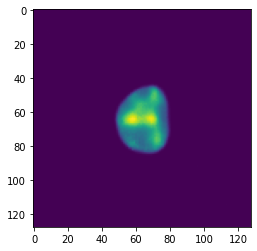

GFAP


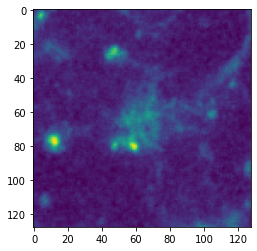

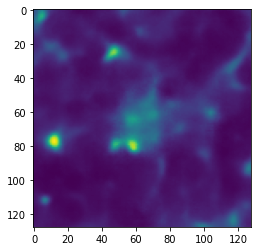

MAP2


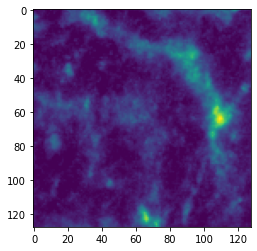

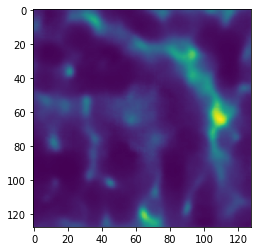

LMNB


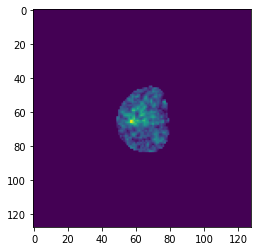

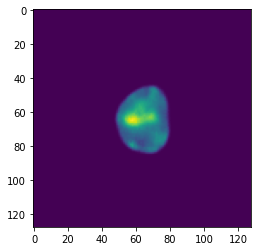

2
DAPI


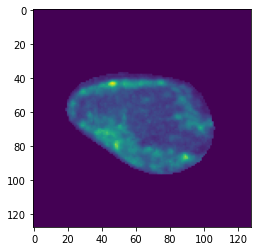

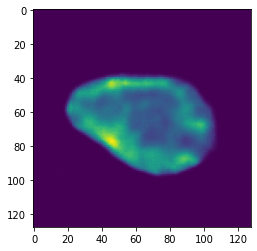

GFAP


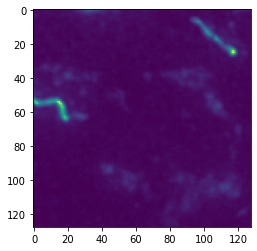

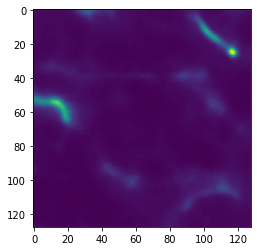

MAP2


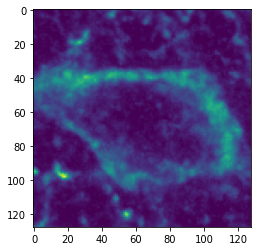

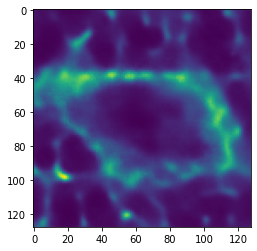

LMNB


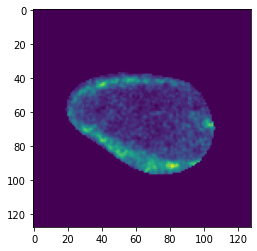

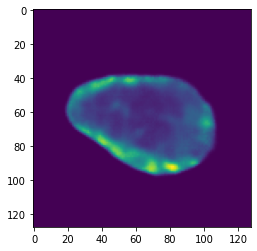

3
DAPI


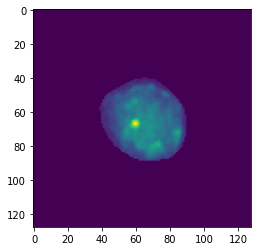

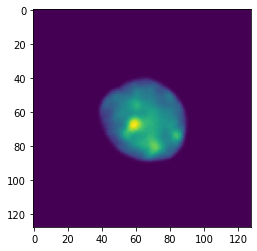

GFAP


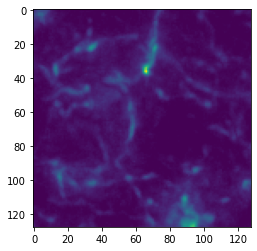

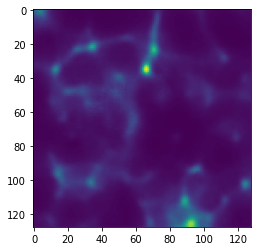

MAP2


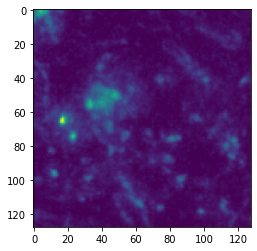

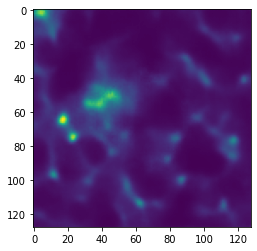

LMNB


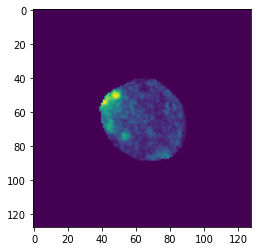

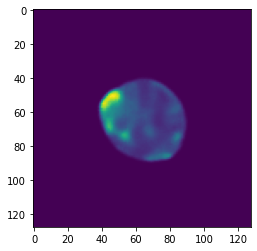

4
DAPI


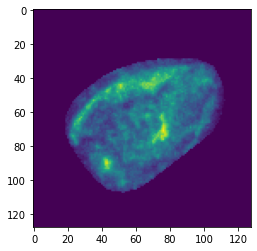

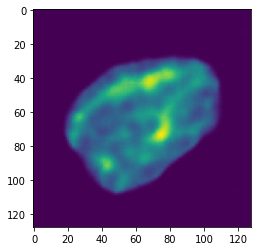

GFAP


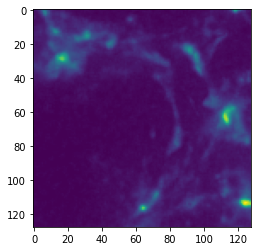

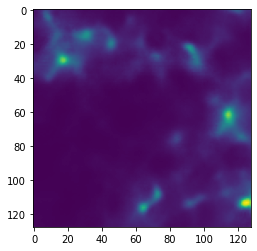

MAP2


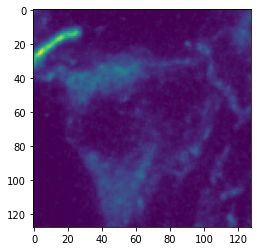

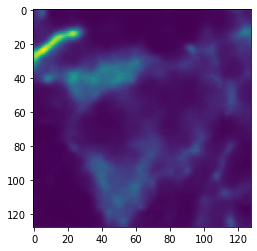

LMNB


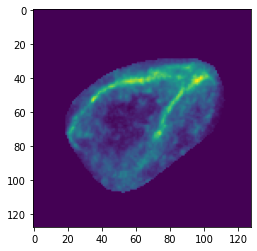

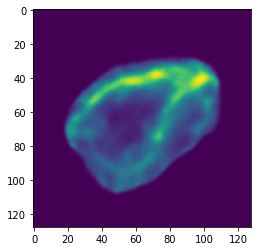

5
DAPI


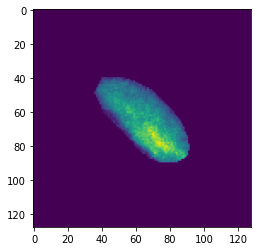

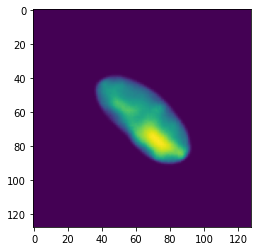

GFAP


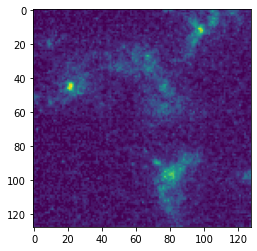

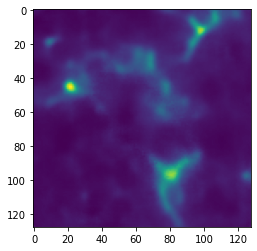

MAP2


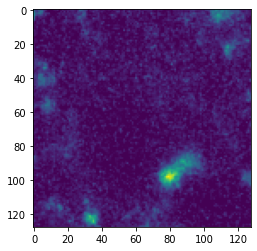

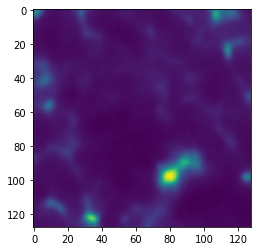

LMNB


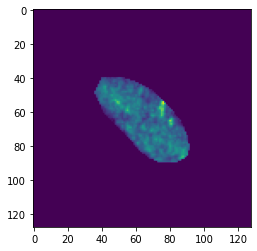

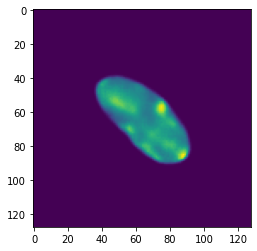

6
DAPI


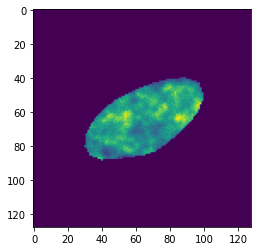

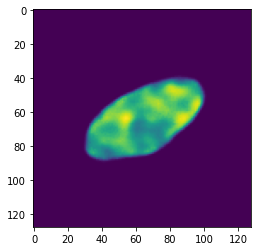

GFAP


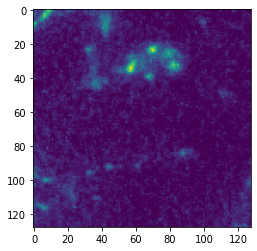

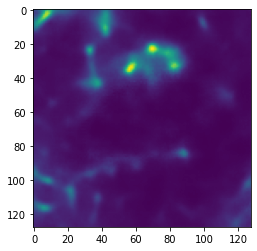

MAP2


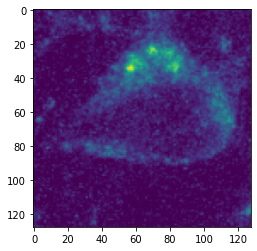

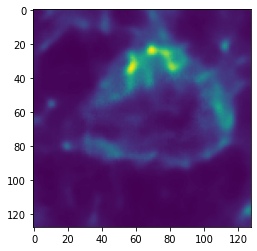

LMNB


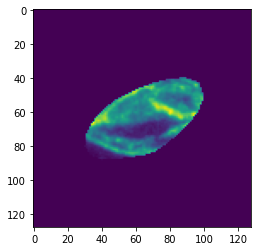

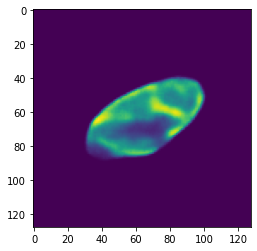

7
DAPI


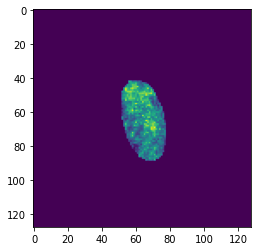

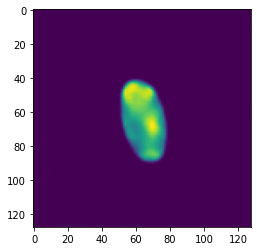

GFAP


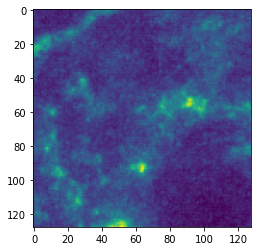

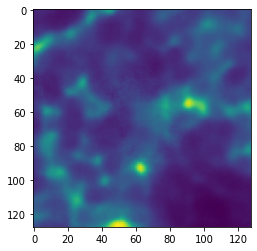

MAP2


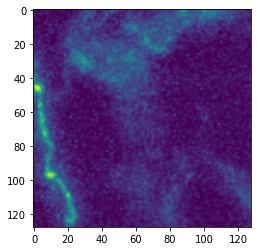

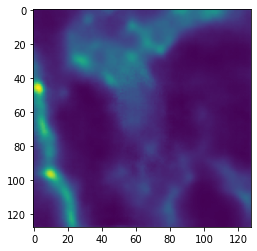

LMNB


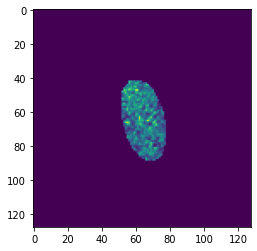

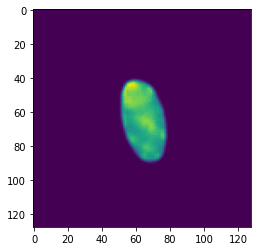

8
DAPI


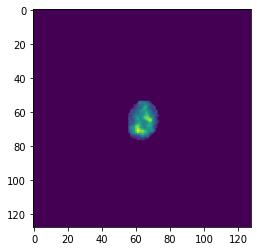

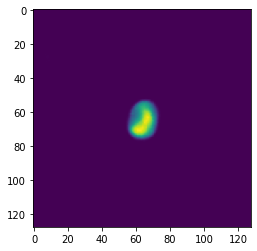

GFAP


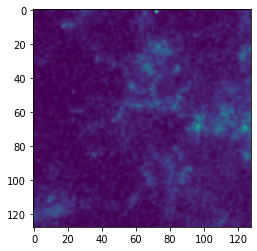

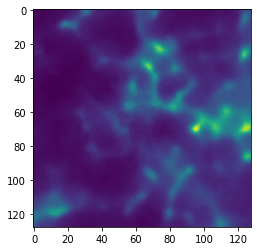

MAP2


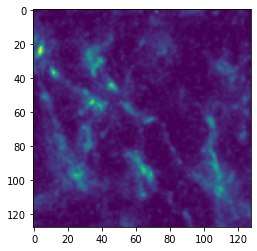

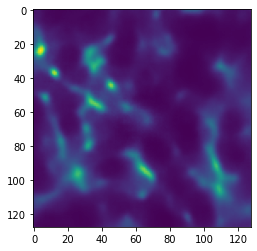

LMNB


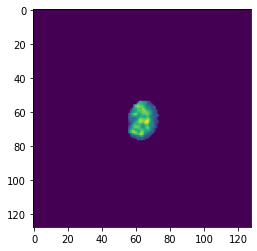

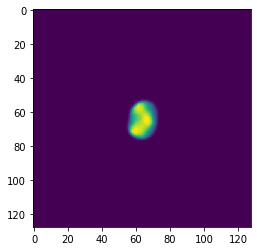

9
DAPI


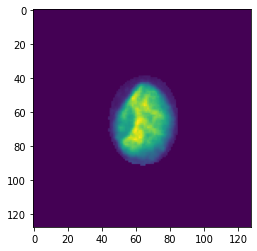

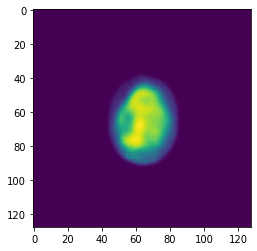

GFAP


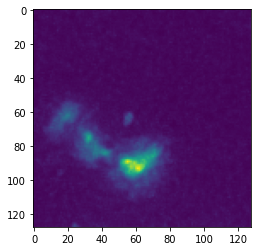

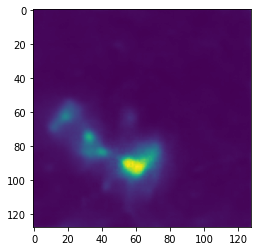

MAP2


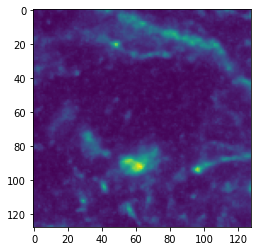

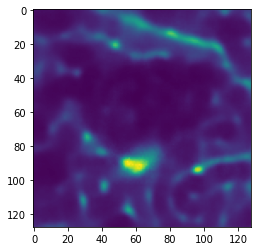

LMNB


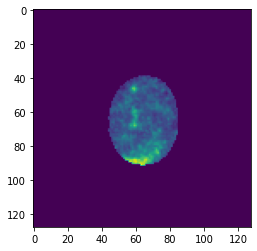

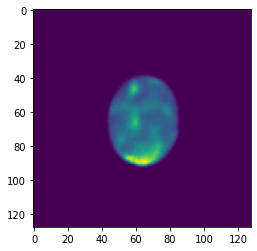

In [14]:
for i in range(10):
    print(i)
    for s in range(len(stains)):
        print(stains[s])
        plt.imshow(testInput[i][s].cpu().detach().numpy())
        plt.show()
        plt.imshow(recon[i][s].cpu().detach().numpy())
        plt.show()

In [16]:
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()


In [17]:
with open(os.path.join(savedir_processed,'allLatent_epoch458_nucSeg'), 'wb') as output:
    pickle.dump(latent, output, pickle.HIGHEST_PROTOCOL)